# XGBoost implementation

In [19]:
# Packages and libraries
import pandas as pd
import xgboost as xgb
import numpy as np

In [20]:
# XGBoost data prep
#remove white space in columns
#NOTE: GENDER_bin=1 is female and GENDER_bin=0 is males

import os

df_stand = pd.read_csv(r'C:\Dokumenter\Dokumenter\UNI\7.semester\Bachelor\Bachelor_Gabi_Kat\Notebooks\Basic_dists\df_standardized_score.csv')
df_norm = pd.read_csv(r'C:\Dokumenter\Dokumenter\UNI\7.semester\Bachelor\Bachelor_Gabi_Kat\Notebooks\Basic_dists\df_normalized_score.csv')

df = pd.read_csv("df_sum_score.csv")
# df.replace(' ','_',regex=True,inplace=True)

# there were 14 missing values, which has earlier been set to 0 in STRATUM. 
# Since this is only approximately 0.116% of the entire data, we do not need to do anything further. 
# XGBoost is very well at handling missing data, and we just need to ensure that it's set to 0. 

# df = df_stand

# df.STRATUM.isin(['0']).sum()

In [21]:
# Splitting the data 
# X is the data which will be used to make predictions, and y contains the data we want to predict.
# We want to predict the score of the students in college, hence y_training and y_test is the college average grade. 

X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_S11','CC_S11','ENG_S11','CR_PRO','CC_PRO','ENG_PRO'], axis=1).copy()
y=df['COL_GRADE_AVG'].copy()

# Now we will continue to formatting X to make it suitable for making a model with XGBoost. 

In [22]:
# One-hot encoding 

# Look at the different types of data contained in each variable. 
X.dtypes

# The object columns we need to inspect to ensure that they are what we need them to be and after that we will do one-hot encoding. 
# One hot encoding is used to make the categorical varoiable STRATUM work in the model. 
# What is gonna happen is that the categorical variable is becoming multiple columns of binary values. 
# One hot encoding works great for trees and this is the motivation for using this method. 
X_encoded = pd.get_dummies(X,columns=['STRATUM'])


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state=24, test_size=0.33)#, stratify=y)

In [24]:
# Creating the data sets as csv's

# Raw data
# X_train.to_csv("X_train_raw.csv")
# X_test.to_csv("X_test_raw.csv") 
# y_train.to_csv("y_train_raw.csv") 
# y_test.to_csv("y_test_raw.csv")

# Standardized
#  X_train.to_csv("X_train_stand.csv")
# X_test.to_csv("X_test_stand.csv") 
# y_train.to_csv("y_train_stand.csv") 
# y_test.to_csv("y_test_stand.csv")



# Regressor

Run from here: 

In [25]:
# Load pre-split data 
# df = pd.read_csv("df_sum_score_py.csv")
# X_train = pd.read_csv("X_train_raw.csv")
# X_test = pd.read_csv("X_test_raw.csv")
# y_train = pd.read_csv("y_train_raw.csv")
# y_test = pd.read_csv("y_test_raw.csv")

In [26]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

In [27]:
# XGBRegressor

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Prediction

In [28]:
y_pred_init = model.predict(X_test)
y_pred_init

array([86.15838 , 84.907745, 86.89197 , ..., 91.33312 , 76.757935,
       59.32007 ], dtype=float32)

# Mean squared error
This is the average squared difference between the estimated values and the actual value.

In [29]:
# Kør disse herunder for at se om det er blevet bedre 
mse_init = mean_squared_error(y_test, y_pred_init)

# Root mean squared error
rmse_init= np.sqrt(mse_init)

print("INITIAL MSE: %.2f" % mse_init)
print("INITIAL RMSE: %.2f" % rmse_init)

INITIAL MSE: 219.97
INITIAL RMSE: 14.83


# Optimize parameters using cross-validation

XGBoost has a lot of hyper parameters which we can manually tune. These are e.g. max_depth of the tree, learning_rate, gamma which encourages pruning of the tree and reg_lambda which is the regularization parameter lambda. We are trying to find the optimal values for these parameters and hope that we can improve the accuracy in the prediction of the candidates college grades. 

# Gridsearch cross validation 

Gridsearch CV will be run sequentially on subsets of different options for the parameters. 


In [129]:
# 1st round
param_grid_1 = {
    'max_depth':[3,4,5],
    'learning_rate':[0.01,0.05,0.1],
    'gamma':[0,0.25,0.1],
    'reg_lambda':[0,0.1,10.0],
    'scale_pos_weight':[1,3,5]
}

In [130]:
from sklearn.model_selection import GridSearchCV


# base_estimator_model = xgb.XGBRegressor()
# clf = GridSearchCV(base_estimator_model, param_grid)
# clf.fit(X_train, y_train)

optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror', seed=24, subsample=0.9),
        param_grid=param_grid_1,
        cv=5).fit(X_train,y_train)
          

KeyboardInterrupt: 

In [ ]:
# optimal parameters 
print(optimal_params.best_params_)


{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


In [ ]:
## Round 2 
param_grid_2 = {
    'max_depth':[2,3],
    'learning_rate':[0.05],
    'gamma':[0,0.01],
    'reg_lambda':[10.0,15.0,20.0],
    'scale_pos_weight':[0.01,0.5,1]
}

In [ ]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror', seed=24, subsample=0.9),
        param_grid=param_grid_2,
        cv=5).fit(X_train,y_train)

In [ ]:
# optimal parameters 
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 15.0, 'scale_pos_weight': 0.01}


In [ ]:
## Round 3 
param_grid_3 = {
    'max_depth':[3],
    'learning_rate':[0.05],
    'gamma':[0],
    'reg_lambda':[15.0],
    'scale_pos_weight':[0.01]
}

In [106]:
final_model = xgb.XGBRegressor(seed=24, objective='reg:squarederror', max_depth=3, learning_rate=0.05, gamma=0,reg_lambda=15.0, scale_pos_weight=0.01)
final_model.fit(X_train,y_train,verbose=True, eval_metric='rmse')
# eval_metric default according to objective

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=24,
             reg_alpha=0, reg_lambda=15.0, scale_pos_weight=0.01, seed=24,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [107]:
scores_final = cross_val_score(final_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores_final.mean())

scores = cross_val_score(model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.60
Mean cross-validation score: 0.56


In [108]:
y_pred_final = final_model.predict(X_test)
y_pred_final

array([86.0275 , 85.41487, 85.96548, ..., 86.64408, 75.97237, 61.03375],
      dtype=float32)

In [109]:
# Kør disse herunder for at se om det er blevet bedre 
mse_final = mean_squared_error(y_test, y_pred_final)
print("FINAL MSE: %.2f" % mse_final)

# Root mean squared error
rmse_final= np.sqrt(mse_final)
print("FINAL RMSE: %.2f" % rmse_final)

# from sklearn.metrics import average_precision_score
# map_final= average_precision_score(y_test, y_pred_final)
# print("FINAL MAP: %.2f" % map_final)

FINAL MSE: 205.79
FINAL RMSE: 14.35


# Results
FOR RAW DATA VANILLA 
Before and after parameter optimization
- MSE: 219.97  (ændring på -6,44%)
- FINAL MSE: 205.79


FOR RAW DATA WITHOUT SENSITIVE 
- INITIAL MSE: 207.27
- FINAL MSE: 205.79





FOR STANDARDIZED DATA 
- INITIAL MSE: 0.42  (ændring på -4,76%)
- FINAL MSE: 0.40


# Reparring the index and predictions 

In [110]:
index = X_test.index.to_numpy()
gender = X_test.GENDER_bin.to_numpy()
preds = y_pred_final
listen = list(map(list, zip(index,gender, preds)))

In [111]:
samlet_preds_index_vanilla = pd.DataFrame(listen, columns=['Idx','Gender_bins','Preds'])
samlet_preds_index_vanilla=samlet_preds_index_vanilla.sort_values(by=['Preds'],ascending=False)
samlet_preds_index_vanilla.to_csv("samlet_preds_index_vanilla.csv")

## Plotting the tree? 
concider plotting the tree

In [78]:
# Prøve at sorte predictions med mergesort 
import numpy as np

pred_sorted = np.sort(y_pred_final, axis=- 1, kind='mergesort')[::-1]
pred_sorted


array([93.66171 , 93.66171 , 93.66171 , ..., 22.908688, 22.679869,
       22.679869], dtype=float32)

# Plotting

In [45]:
import matplotlib as mpl
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

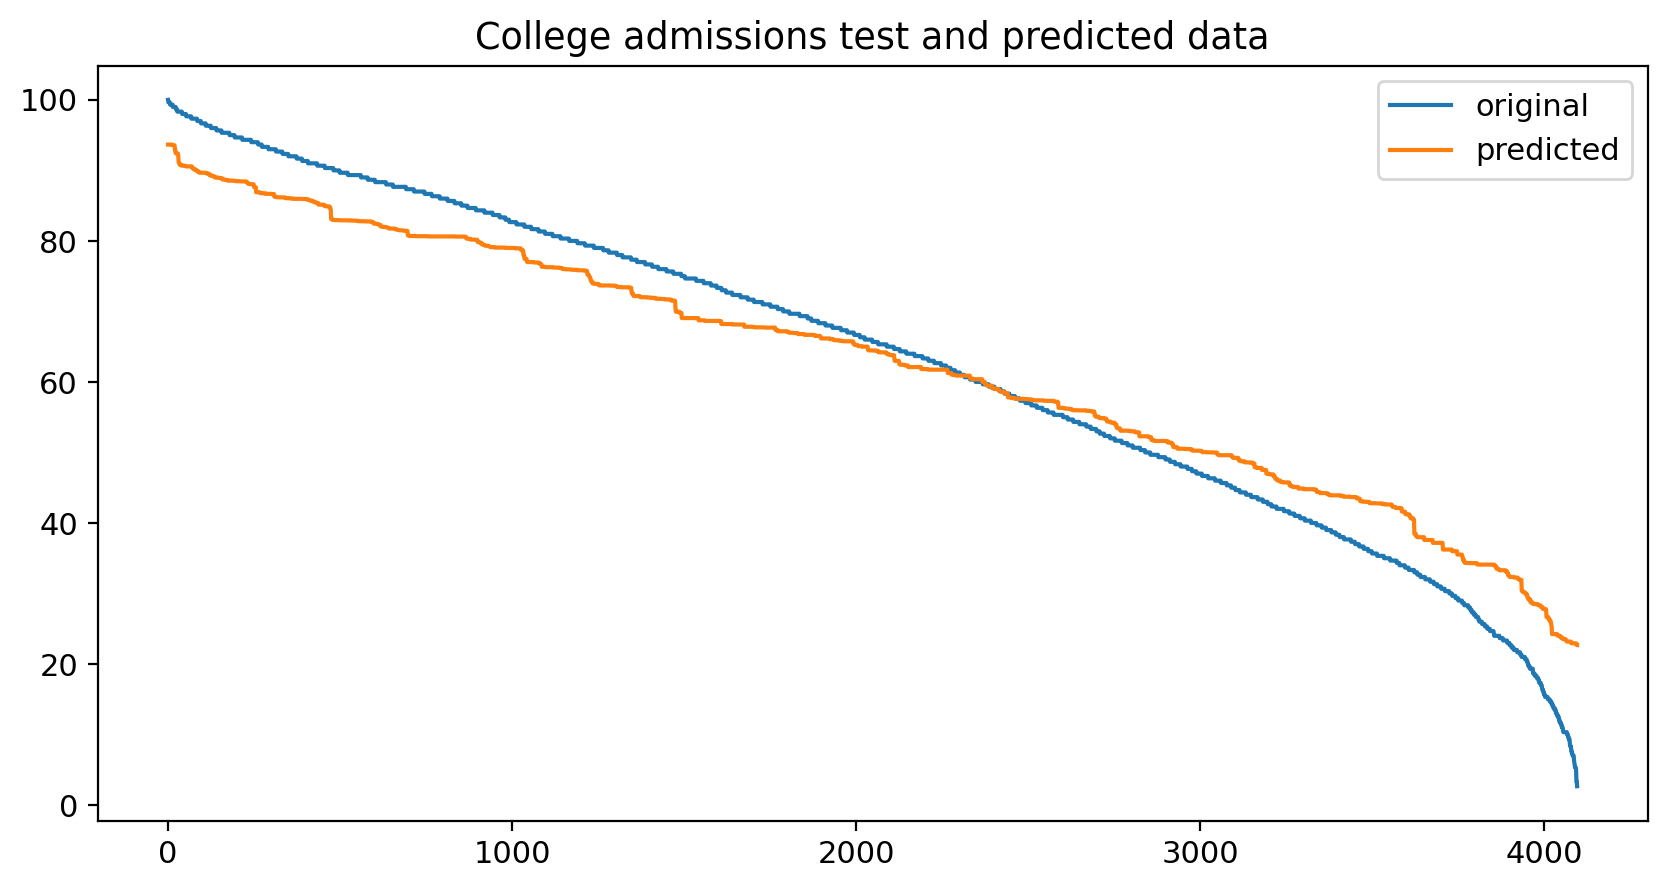

<Figure size 2000x1000 with 0 Axes>

In [47]:

x_ax = range(len(y_test))
y_test_sorted = np.sort(y_test, axis=- 1, kind='mergesort')[::-1]
plt.plot(x_ax, y_test_sorted, label="original")
plt.plot(x_ax, pred_sorted, label="predicted")
plt.title("College admissions test and predicted data")
plt.legend()
plt.show()
plt.savefig("plot_xgb_vanilla.png")

# XGBoost without sensitive attributes

In [1]:
# Splitting the data 
# X is the data which will be used to make predictions, and y contains the data we want to predict.
# We want to predict the score of the students in college, hence y_training and y_test is the college average grade. 
import pandas as pd
df = pd.read_csv("df_sum_score.csv")

In [2]:
X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_S11','CC_S11','ENG_S11','CR_PRO','CC_PRO','ENG_PRO', 'STRATUM','GENDER_bin'], axis=1).copy()
y = df['COL_GRADE_AVG'].copy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=24, test_size=0.33)#, stratify=y)

In [3]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import xgboost as xgb
import numpy as np
# XGBRegressor

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

y_pred_init = model.predict(X_test)
y_pred_init

# Mean squared error
# This is the average squared difference between the estimated values and the actual value.
# Kør disse herunder for at se om det er blevet bedre 
mse_init = mean_squared_error(y_test, y_pred_init)

# Root mean squared error
rmse_init= np.sqrt(mse_init)

print("INITIAL MSE: %.2f" % mse_init)
print("INITIAL RMSE: %.2f" % rmse_init)
# Optimize parameters using cross-validation


INITIAL MSE: 207.27
INITIAL RMSE: 14.40


In [4]:

# # XGBoost has a lot of hyper parameters which we can manually tune. These are e.g. max_depth of the tree, learning_rate, gamma which encourages pruning of the tree and reg_lambda which is the regularization parameter lambda. We are trying to find the optimal values for these parameters and hope that we can improve the accuracy in the prediction of the candidates college grades. 
# # Gridsearch cross validation 

# # Gridsearch CV will be run sequentially on subsets of different options for the parameters. 

# # 1st round
# param_grid_1 = {
#     'max_depth':[3,4,5],
#     'learning_rate':[0.01,0.05,0.1],
#     'gamma':[0,0.25,0.1],
#     'reg_lambda':[0,0.1,10.0],
#     'scale_pos_weight':[1,3,5]
# }
# from sklearn.model_selection import GridSearchCV


# # base_estimator_model = xgb.XGBRegressor()
# # clf = GridSearchCV(base_estimator_model, param_grid)
# # clf.fit(X_train, y_train)

# optimal_params = GridSearchCV(
#     estimator=xgb.XGBRegressor(
#         objective='reg:squarederror', seed=24, subsample=0.9),
#         param_grid=param_grid_1,
#         cv=5).fit(X_train,y_train)
          
# # optimal parameters 
# print(optimal_params.best_params_)

# ## Round 2 
# param_grid_2 = {
#     'max_depth':[2,3],
#     'learning_rate':[0.05],
#     'gamma':[0,0.01],
#     'reg_lambda':[10.0,15.0,20.0],
#     'scale_pos_weight':[0.01,0.5,1]
# }
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBRegressor(
#         objective='reg:squarederror', seed=24, subsample=0.9),
#         param_grid=param_grid_2,
#         cv=5).fit(X_train,y_train)
# # optimal parameters 
# print(optimal_params.best_params_)
# ## Round 3 
# param_grid_3 = {
#     'max_depth':[3],
#     'learning_rate':[0.05],
#     'gamma':[0],
#     'reg_lambda':[15.0],
#     'scale_pos_weight':[0.01]
# }


In [5]:

final_model = xgb.XGBRegressor(seed=24, objective='reg:squarederror', max_depth=3, learning_rate=0.05, gamma=0,reg_lambda=15.0, scale_pos_weight=0.01)
final_model.fit(X_train,y_train,verbose=True, eval_metric='rmse')
# eval_metric default according to objective
scores_final = cross_val_score(final_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores_final.mean())

scores = cross_val_score(model, X_train, y_train, cv=10)
y_pred_final = final_model.predict(X_test)
y_pred_final


Mean cross-validation score: 0.60


array([85.84178, 85.84178, 85.84178, ..., 86.54498, 75.68213, 63.15874],
      dtype=float32)

In [6]:
# Kør disse herunder for at se om det er blevet bedre 
mse_final = mean_squared_error(y_test, y_pred_final)
print("FINAL MSE: %.2f" % mse_final)

# Root mean squared error
rmse_final= np.sqrt(mse_final)
print("FINAL RMSE: %.2f" % rmse_final)


FINAL MSE: 206.32
FINAL RMSE: 14.36


FOR RAW DATA 
Before and after parameter optimization
- MSE: 219.97  (ændring på -6,44%)
- RMSE: 14.83   (ændring på -3,23 %)

- FINAL MSE: 205.79

- FINAL RMSE: 14.35




FOR STANDARDIZED DATA 

- INITIAL MSE: 0.42  (ændring på -4,76%)

- INITIAL RMSE: 0.65
- FINAL MSE: 0.40
- FINAL RMSE: 0.63

In [7]:
# Reparring the index and predictions 
# X_test
index = X_test.index.to_numpy()
# gender = X_test.GENDER_bin.to_numpy()
preds = y_pred_final
listen = list(map(list, zip(index, preds)))


samlet_preds_index_without_sensitive = pd.DataFrame(listen, columns=['Idx','Preds'])
samlet_preds_index_without_sensitive=samlet_preds_index_without_sensitive.sort_values(by=['Preds'],ascending=False)
samlet_preds_index_without_sensitive.to_csv("samlet_preds_index_without_sensitive.csv")

findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


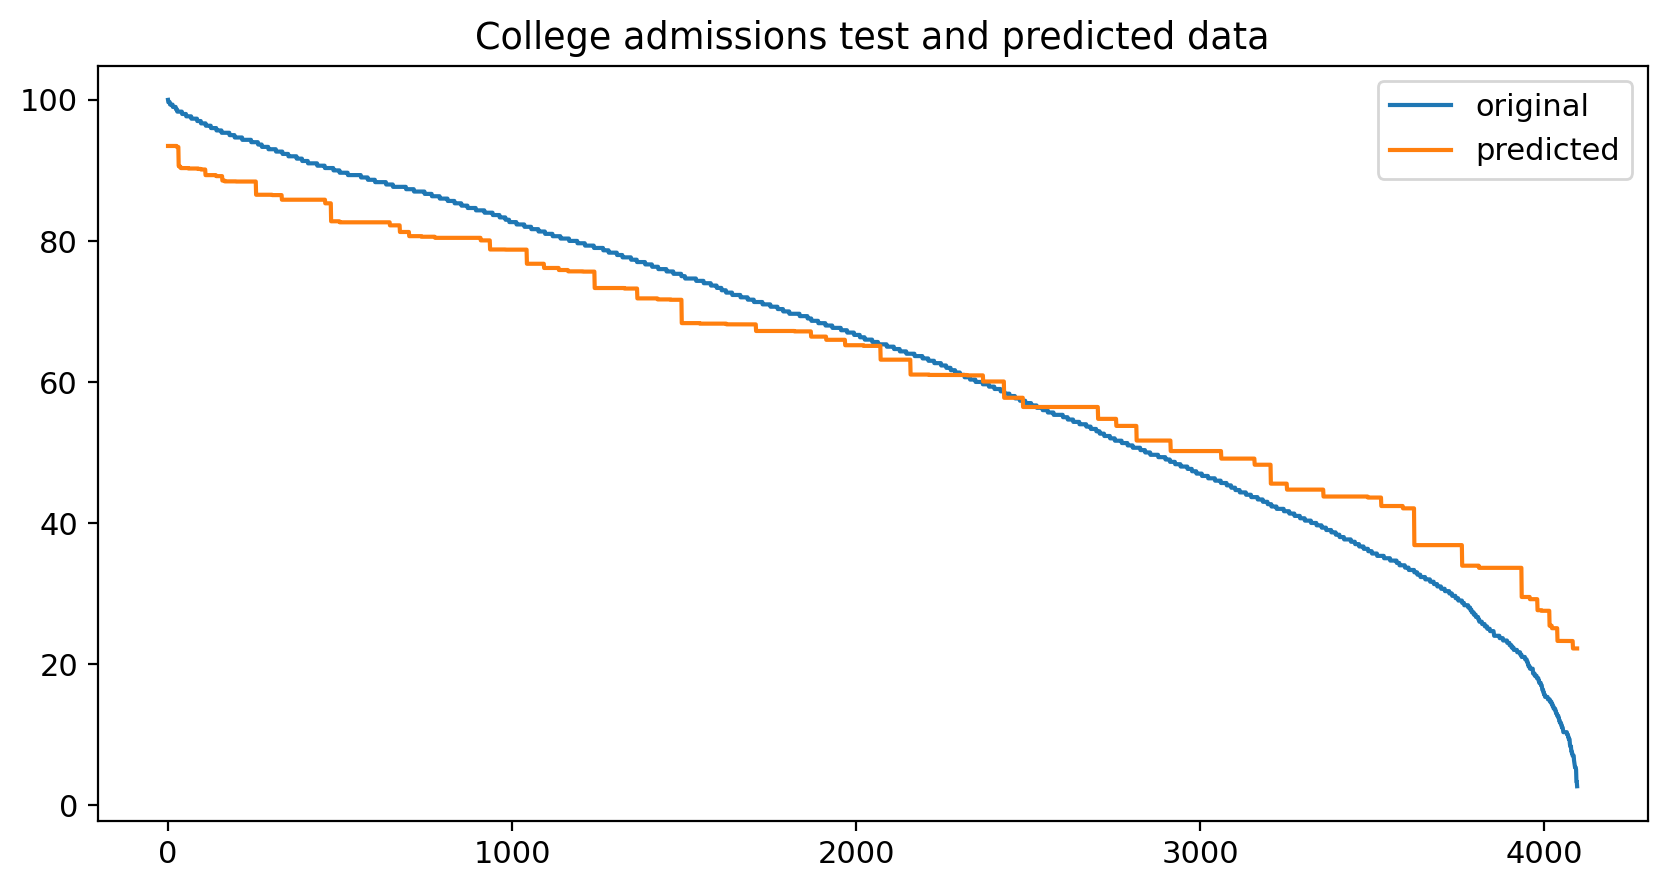

<Figure size 2000x1000 with 0 Axes>

In [8]:

## Plotting the tree? 
# concider plotting the tree

# Muligvis skal vitage og concat y_test.index og y_pred for at få index på predictions. Så vi kan sorte dem og se om der er en bestemt tendens. 
# Prøve at sorte predictions med mergesort 


pred_sorted = np.sort(y_pred_final, axis=- 1, kind='mergesort')[::-1]
pred_sorted

# Plotting
import matplotlib as mpl
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

x_ax = range(len(y_test))
y_test_sorted = np.sort(y_test, axis=- 1, kind='mergesort')[::-1]
plt.plot(x_ax, y_test_sorted, label="original")
plt.plot(x_ax, pred_sorted, label="predicted")
plt.title("College admissions test and predicted data")
plt.legend()
plt.show()
plt.savefig("plot_xgb_without sensitive.png")


In [11]:
# TODO måske kan noget af dette bruges???
def c_statistic_harrell(pred_sorted, y_test):
    total = 0
    matches = 0
    for i in range(len(y_test)):
        for j in range(len(y_test)):
            if y_test[j] > 0 and abs(y_test[i]) > y_test[j]:
                total += 1
                if pred_sorted[j] > pred_sorted[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(final_model.predict(xgb_test, ntree_limit=5000), y_test)

NameError: name 'xgb_test' is not defined